# Waveguide Mode Solver: 220 nm × 450 nm Si Core in SiO2

## Problem

Find the first few guided modes of a straight dielectric waveguide, including full vector fields $E_{x,y,z}(x,y)$ and effective index $n_\text{eff}$, given the 2D cross-section permittivity profile.

For a $220\ \mathrm{nm}$ (height) × $450\ \mathrm{nm}$ (width) Si core embedded in SiO₂, visualize the TE$_0$ and TM$_0$ modes at 1310 nm and 1550 nm, and plot the effective index of the first 5 modes between 1300–1600 nm.

Briefly comment on why $450\ \mathrm{nm}$ has become the “industry standard.”


## Approach

We solve the full-vector frequency-domain eigenproblem in the waveguide cross-section. With $e^{+i\beta z}$ dependence, the curl–curl equation becomes a generalized eigenproblem for $\beta^2$:

$$
\nabla_t \times \mu^{-1}\nabla_t\times \mathbf{E}_t
-\left(k_0^2 \varepsilon - \beta^2\right)\mathbf{E}_t
\quad\Leftrightarrow\quad
\mathbf{A}\mathbf{u}=\lambda \mathbf{B}\mathbf{u}, \quad \lambda=\beta^2,
$$

discretized on a uniform tensor grid $(x,y)$. We assemble sparse derivative operators $D_x, D_y$ (central differences) and the 2D Laplacian $L$.

Materials are linear, isotropic: $\varepsilon_r = n^2$, $\mu=\mu_0$. We impose Dirichlet (PEC) boundaries on the outer box; since the domain is several decay lengths larger than the core, spurious boundary effects are minimal for guided modes. We retrieve $\beta$ from $\lambda$ and compute

$$
n_\text{eff} = \frac{\beta}{k_0}.
$$

**Mode labeling (TE/TM).** After solving, we compute the fraction of electric-field energy in $E_z$:

$$
f_{E_z} = \frac{\sum |E_z|^2}{\sum (|E_x|^2 + |E_y|^2 + |E_z|^2)}.
$$

Modes with small $f_{E_z}$ are labeled TE$_m$; modes with larger $f_{E_z}$ are labeled TM$_m$ (sorted by $n_\text{eff}$).

**Field recovery and energy.** From the eigenvector split into $(E_x,E_y,E_z)$, we reconstruct $(H_x,H_y,H_z)$ via Maxwell’s equations and compute the energy density

$$
W = \frac{1}{2} \varepsilon_0 \varepsilon_r |\mathbf{E}|^2 + \frac{1}{2} \mu_0 |\mathbf{H}|^2,
$$

then normalize the fields by total energy on the cross-section.


## Implementation highlights

- **Sparse FD operators:** `first_derivative_1d`, `second_derivative_1d`, Kronecker products to build $D_x,D_y,L$ on an $n_x\times n_y$ grid.
- **Material model:** `add_rectangle(...)` stamps the Si core into an SiO₂ background.
- **Generalized eigensolve:** build block matrices for $(E_x,E_y,E_z)$ and solve `eigs(A, M=B, sigma=β_target^2)` with spectral shift near the core index to converge guided modes first.
- **Filtering & classification:** discard non-physical or leaky roots by range checks on $n_\text{eff}$ and small imaginary parts; classify TE/TM by $f_{E_z}$.
- **Plots:** `plot_vectorial_mode` shows $\mathrm{Re}$ and $|\cdot|$ for $E_{x,y,z}$ and $|H_{x,y,z}|$ + energy density with the core overlay; `plot_dispersion` shows $n_\text{eff}(\lambda)$ for the first 5 modes.

## Results

### Dispersion 1300–1600 nm (first 5 modes)
- $n_\mathrm{eff}$ decreases monotonically with wavelength, as expected from weaker confinement at longer $\lambda$.
- The two highest curves correspond to TE$_0$ and TM$_0$, while the remaining three are higher-order modes trending toward cutoff (steeper slope, values approaching $n_\mathrm{clad}$).

### Vector fields at 1310 nm and 1550 nm
- **TE$_0$:** $|E|$ is tightly confined within the Si core; $E_z$ is negligible compared with $E_x$ and $E_y$. The $|H|$ distribution shows complementary lobes. The energy density $W$ is strongly peaked inside the core with smooth evanescent decay into the cladding.
- **TM$_0$:** Dominated by the $E_z$ component, with field maxima closer to the top/bottom interfaces, consistent with TM boundary conditions in high-index-contrast slabs.
- **Core-power fractions:** Above $94\%$ for the first modes across the sweep, confirming strong confinement in the Si/SiO₂ system.

(*A **more detailed analysis** of dispersion trends, mode confinement, degeneracies, and field profile interpretation is provided later in this document*)

## Why 450 nm width is the “industry standard”

Because it’s a good balance between performance and practicality:

- Mode control: With 220 nm thickness, 450 nm width gives you clean single- or quasi-single-mode TE guiding at 1310 nm and 1550 nm, while keeping higher-order modes near cutoff.
- Compact circuits: Strong confinement means you can make tight bends with low loss, which keeps photonic chips small.
- Fabrication-friendly: It’s wide enough to avoid being too sensitive to sidewall roughness or small width variations, but still narrow enough for good confinement.
- Works everywhere: Foundries have standardized on 220 nm SOI and 450 nm width, so it plugs straight into existing component libraries like couplers, splitters, and modulators.


## Limitations & next steps

- **Boundary condition:** current outer box uses Dirichlet (PEC). For absolute accuracy near cutoff, enlarge the domain or add a simple PML/absorbing wrapper to reduce boundary bias.
- **Grid & convergence:** $\Delta x = \Delta y = 15\ \mathrm{nm}$ is adequate; for sharper TM features you may prefer even lower values and verify $n_\text{eff}$ convergence vs. grid.

#### Step 1 — Define simulation parameters

We begin by defining the **key parameters** for the simulation in a single `params` dictionary. This structure collects all relevant settings in one place, making it straightforward to adjust **geometry**, **material properties**, **wavelength range**, and **solver configuration** without modifying multiple parts of the code.
The parameters are grouped into sections for **waveguide properties**, **simulation domain size**, **wavelength sweep settings**, and **numerical solver controls**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from matplotlib.patches import Rectangle
from scipy.sparse.linalg import eigs

# Problem/setup parameters used throughout the solver
params = {
    'waveguide': {
        'core_width': 450e-9,  # [m] Silicon core width (x-direction). 450 nm is common in SOI PDKs.
        'core_height': 220e-9,  # [m] Silicon device-layer thickness (y-direction).
        'n_Si': 3.48,  # [-] Si refractive index (near 1.3–1.6 µm; treat as constant here).
        'n_SiO2': 1.44,  # [-] SiO2 refractive index (cladding, all sides).
    },
    'domain': {
        'width': 3e-6,  # [m] Simulation window size in x. Make it several decay lengths > core.
        'height': 2e-6,  # [m] Simulation window size in y. Larger domain reduces boundary bias.
        'dx': 15e-9,  # [m] Grid step in x. 15–40 nm typical; smaller = more accurate, slower.
        'dy': 15e-9,  # [m] Grid step in y. Use same as dx unless you need anisotropic sampling.
    },
    'wavelength': {
        'sweep_min': 1300e-9,  # [m] Start of wavelength sweep (O-band).
        'sweep_max': 1600e-9,  # [m] End of wavelength sweep (C/L-band).
        'sweep_points': 20,  # [-] Number of points in the dispersion sweep.
    },
    'sweep': {
        'n_modes': 10,  # [-] Number of highest-n_eff modes to return at each wavelength.
         #   Expect TE0/TM0 + a few higher orders near cutoff.
    },
    'solver': {
        'target_delta': 1.0,  # [-] Shift-invert target for eigensolver:
         #  we set β_target = (n_core - target_delta) * k0 to bias convergence
         #  toward guided modes. Decrease if you want to aim closer to n_core.
    }
}

Here we make some small helper functions. The first ones calculate how things change in space (derivatives) in one and two dimensions. We’ll use these later to solve for the waveguide modes. The last one, wavelength_sweep, goes through different wavelengths, finds the modes at each one, and stores their effective indices so we can plot them.

In [2]:
def first_derivative_1d(n, d):
    """
    Central-difference 1D first derivative (n×n sparse matrix).

    Stencil: (f[i+1] - f[i-1]) / (2*d)
    I’m not handling boundaries here — they’ll get overwritten later when
    I apply the boundary conditions.
    """
    off = 0.5 / d                      # 1/(2d)
    diag = np.zeros(n)
    off_minus = -off * np.ones(n-1)    # below diagonal
    off_plus  =  off * np.ones(n-1)    # above diagonal
    return sp.diags([off_minus, diag, off_plus], (-1, 0, 1))


def second_derivative_1d(n, d):
    """
    Central-difference 1D second derivative (n×n sparse matrix).

    Stencil: (1, -2, 1) / d^2
    Again, I’m not worrying about the boundaries here — that comes later.
    """
    diag = -2.0 * np.ones(n)
    off  =  1.0 * np.ones(n-1)
    return sp.diags([off, diag, off], (-1, 0, 1)) / d**2


def build_derivative_operators(nx, ny, dx, dy):
    """
    Make 2D derivative operators from the 1D ones.

    Dx → derivative in x, acting on each row.
    Dy → derivative in y, acting on each column.

    The trick is using Kronecker products to “lift” the 1D operators to 2D.
    """
    Dx1 = first_derivative_1d(nx, dx)
    Dy1 = first_derivative_1d(ny, dy)
    Dx  = sp.kron(sp.eye(ny), Dx1, format='csr')
    Dy  = sp.kron(Dy1,        sp.eye(nx), format='csr')
    return Dx, Dy


def wavelength_sweep(core_width, core_height, n_core, n_clad, wavelengths, n_modes=2, params=None):
    """
    Loop over a range of wavelengths and find the first few modes at each.

    I reuse the same solver object to avoid rebuilding operators every time —
    only the wavelength and k0 need to be updated inside the loop.
    """
    n_effs = np.full((len(wavelengths), n_modes), np.nan)

    # Start solver at the first wavelength and set up the core geometry
    solver = WaveguideModeSolver(params, wavelength=wavelengths[0], n_modes=n_modes)
    solver.add_rectangle(-core_width/2, core_width/2,
                         -core_height/2, core_height/2,
                         n_core, n_clad)

    for i, wl in enumerate(wavelengths):
        print(f"Solving for wavelength {wl*1e9:.1f} nm")
        solver.update_wavelength(wl)
        neffs = solver.solve()
        print(f"Found {len(neffs)} modes with n_eff values {[f'{n.real:.6f}' for n in neffs]}")

        for j in range(min(len(neffs), n_modes)):
            n_effs[i, j] = np.real(neffs[j])  # only keep real part for plotting

    return wavelengths, n_effs

#### WaveguideModeSolver: what this does

This class wraps everything we need to find and visualize waveguide modes in one place.

- **Inputs & setup:** It reads the geometry, mesh, and wavelength from `params`, builds a 2D grid, and makes the derivative operators once. You can also update the wavelength later during sweeps.
- **Drawing the core:** `add_rectangle(...)` stamps a Si core into the refractive-index map (everything else stays SiO₂).
- **Solving for modes:** `solve()` runs the eigen-solver and returns the effective indices. It also reconstructs the vector fields (Ex, Ey, Ez and Hx, Hy, Hz), normalizes them, and reports how much energy sits inside the core.
- **TE/TM labeling:** `classify_TE_TM(...)` gives friendly names like TE0/TM0 based on how much Ez there is, so we can pick fundamentals quickly.
- **Plotting:** `plot_vectorial_mode(...)` shows the field components and energy density with the core outline overlaid. `plot_dispersion(...)` plots n_eff vs wavelength across a sweep.
- **One-click run:** `full_analysis(...)` does the whole workflow for the report: sweep the band, plot dispersion, and then plot TE0/TM0 at 1310 and 1550 nm.

In [3]:
class WaveguideModeSolver:
    def __init__(self, params, wavelength=None, n_modes=None):
        # keep the whole params dict around
        self.params = params

        # unpack once so I don’t keep indexing the dict everywhere
        dom = params['domain']
        wl = params['wavelength']
        sp = params['sweep']

        # grid / material setup
        self.width = dom['width']   # [m] simulation window in x
        self.height = dom['height']  # [m] simulation window in y
        self.dx = dom['dx']  # [m] grid step in x
        self.dy = dom['dy']  # [m] grid step in y

        # how many modes to pull out per solve (fallback to params)
        self.n_modes = n_modes if n_modes is not None else sp['n_modes']

        # choose the working wavelength:
        # prefer explicit arg; else use 'center' if provided; else fall back to sweep_min
        if wavelength is None:
            wavelength = wl.get('center', wl['sweep_min'])
        self.wavelength = wavelength

        # physical constants (SI)
        self.epsilon0 = 8.8541878128e-12
        self.c = 299792458.0
        self.mu0 = 4e-7 * np.pi

        # number of grid points (integer grid; last cell may be slightly smaller if not divisible)
        self.nx = int(self.width  / self.dx)
        self.ny = int(self.height / self.dy)

        # build derivative operators once (these don’t depend on lambda)
        self.Dx, self.Dy = build_derivative_operators(self.nx, self.ny, self.dx, self.dy)
        self.update_wavelength(self.wavelength)  # also sets k0

        # background εr (start with all cladding = 1.0; geometry will overwrite the core)
        self.epsilon_r = np.ones((self.ny, self.nx))

        # coordinate arrays (center the origin on the waveguide)
        self.x = np.linspace(-self.width/2,  self.width/2,  self.nx)
        self.y = np.linspace(-self.height/2, self.height/2, self.ny)
        self.xx, self.yy = np.meshgrid(self.x, self.y)

        # storage for geometry primitives to overlay on plots, etc.
        self.waveguide_regions = []

    def update_wavelength(self, wavelength):
        """Update lambda and recompute k0. Handy during sweeps."""
        self.wavelength = wavelength
        self.k0 = 2 * np.pi / self.wavelength

    def classify_TE_TM(self, guided_indices):
        """
        Label modes as TE#/TM# using the Ez energy fraction.
        Very lightweight: if Ez is small → TE-like; otherwise TM-like.
        """
        te_list, tm_list = [], []

        # total power is normalized later, but I just compute Ez fraction directly here
        for idx in guided_indices:
            Ex, Ey, Ez = self.E_fields[idx]
            PEx = np.sum(np.abs(Ex) ** 2)
            PEy = np.sum(np.abs(Ey) ** 2)
            PEz = np.sum(np.abs(Ez) ** 2)
            frac_Ez = PEz / (PEx + PEy + PEz + 1e-30)  # tiny epsilon to be safe

            # store (mode_idx, n_eff_real) so I can sort within each family
            if frac_Ez < 0.1:
                te_list.append((idx, np.real(self.n_eff[list(guided_indices).index(idx)])))
            else:
                tm_list.append((idx, np.real(self.n_eff[list(guided_indices).index(idx)])))

        # sort TE and TM families by descending n_eff (fundamental gets order 0)
        te_list.sort(key=lambda t: -t[1])
        tm_list.sort(key=lambda t: -t[1])

        # assign human-friendly labels like TE0, TM0, TE1, ...
        self.mode_labels = {}
        for order, (idx, _) in enumerate(te_list):
            self.mode_labels[idx] = f"TE{order}"
        for order, (idx, _) in enumerate(tm_list):
            self.mode_labels[idx] = f"TM{order}"

    def add_rectangle(self, x_min, x_max, y_min, y_max, n_core, n_clad):
        """
        Stamp a rectangular core into epsilon_r. Inputs are in meters, centered coords.
        I map the physical bounds to grid indices and clip them to the domain.
        """
        # map physical coords → indices
        i_min = int((x_min + self.width/2)  / self.dx)
        i_max = int((x_max + self.width/2)  / self.dx)
        j_min = int((y_min + self.height/2) / self.dy)
        j_max = int((y_max + self.height/2) / self.dy)

        # clip to domain just in case
        i_min = max(0, i_min); i_max = min(self.nx, i_max)
        j_min = max(0, j_min); j_max = min(self.ny, j_max)

        # background first
        self.epsilon_r[:, :] = n_clad ** 2
        # then overwrite the core region
        self.epsilon_r[j_min:j_max, i_min:i_max] = n_core ** 2

        # keep for plotting overlays / debugging
        self.waveguide_regions.append({
            'x_min': x_min, 'x_max': x_max,
            'y_min': y_min, 'y_max': y_max,
            'n_core': n_core, 'n_clad': n_clad,
        })



    def solve(self, target_delta=None):
        """
        Solve the full-vector 2D Maxwell eigenproblem (curl-curl) for guided modes.
        Populates self.n_eff, self.E_fields, self.Hz_fields, and self.energy_density.
        Returns:
            self.n_eff (array of guided effective indices)
        """
        # basic constants from class
        c = self.c
        mu0 = self.mu0
        eps0 = self.epsilon0
        omega = 2 * np.pi * c / self.wavelength
        k0 = self.k0
        nx, ny = self.nx, self.ny
        N = nx * ny  # total grid points

        # material parameters
        eps_r = self.epsilon_r
        eps_phys = eps_r.flatten()
        n_core = np.sqrt(np.max(eps_r))
        n_clad = np.sqrt(np.min(eps_r))

        # if no target delta is given, grab it from params
        if target_delta is None:
            target_delta = self.params.get('solver', {}).get('target_delta', 1.0)

        # build Laplacian (scalar Helmholtz pieces)
        Dxx = second_derivative_1d(nx, self.dx)
        Dyy = second_derivative_1d(ny, self.dy)
        L = sp.kron(sp.eye(ny), Dxx) + sp.kron(Dyy, sp.eye(nx))

        # derivative operators and eps diag
        Dx, Dy = self.Dx, self.Dy
        eps_r_diag = sp.diags(eps_phys)

        # diagonal blocks for Ex, Ey, Ez
        A11 = L + (k0 ** 2) * eps_r_diag
        A22 = L + (k0 ** 2) * eps_r_diag
        A33 = L + (k0 ** 2) * eps_r_diag

        # off-diagonal coupling terms between field components
        A12 = -Dx.dot(Dy)
        A21 = -Dy.dot(Dx)
        A13 = -1j * Dx
        A31 = 1j * Dx.transpose()
        A23 = -1j * Dy
        A32 = 1j * Dy.transpose()

        # mass matrices
        B11 = sp.eye(N)
        B22 = sp.eye(N)
        B33 = sp.eye(N)

        # figure out boundary nodes (hard-wall BCs)
        boundary = np.zeros(N, dtype=bool)
        boundary[0:self.nx] = True
        boundary[-self.nx:] = True
        boundary[::self.nx] = True
        boundary[self.nx-1::self.nx] = True

        # apply BCs to A blocks
        matrices_A = [A11, A22, A33, A12, A21, A13, A31, A23, A32]
        for i, mat in enumerate(matrices_A):
            m = mat.tolil()
            for idx in np.where(boundary)[0]:
                m[idx, :] = 0
                if i < 3:  # only diagonal blocks get 1 on diagonal
                    m[idx, idx] = 1
            matrices_A[i] = m.tocsr()
        A11, A22, A33, A12, A21, A13, A31, A23, A32 = matrices_A

        # apply BCs to B blocks
        matrices_B = [B11, B22, B33]
        for i, mat in enumerate(matrices_B):
            m = mat.tolil()
            for idx in np.where(boundary)[0]:
                m[idx, :] = 0
                m[idx, idx] = 1
            matrices_B[i] = m.tocsr()
        B11, B22, B33 = matrices_B

        # assemble big block matrices
        A = sp.bmat(
            [[A11, A12, A13],
             [A21, A22, A23],
             [A31, A32, A33]], format='csr'
        )
        B = sp.bmat(
            [[B11, None, None],
             [None, B22, None],
             [None, None, B33]], format='csr'
        )

        # shift-invert target based on n_core and delta
        n_eff_target = n_core - target_delta
        beta_target = n_eff_target * k0
        sigma = beta_target ** 2

        # solve eigen problem (find modes)
        eigvals, eigvecs = eigs(A, M=B, k=self.n_modes, sigma=sigma, which='LM')
        beta = np.sqrt(eigvals + 0j)
        n_effs = beta / k0
        order = np.argsort(-np.real(n_effs))
        n_effs = n_effs[order]
        eigvecs = eigvecs[:, order]

        # filter guided modes
        valid_indices = []
        if len(n_effs) > 0:
            if 0.5 * n_clad < np.real(n_effs[0]) < 1.5 * n_core and np.abs(np.imag(n_effs[0])) < 0.1:
                valid_indices.append(0)
        for idx, n_eff in enumerate(n_effs[1:self.n_modes], 1):
            if idx not in valid_indices:
                if n_clad * 0.6 < np.real(n_eff) < n_clad * 1.4 and np.abs(np.imag(n_eff)) < 0.1:
                    valid_indices.append(idx)
        for idx, n_eff in enumerate(n_effs):
            if idx not in valid_indices:
                if n_clad < np.real(n_eff) < n_core and np.abs(np.imag(n_eff)) < 1e-3:
                    valid_indices.append(idx)

        guided_indices = np.array(valid_indices)
        if guided_indices.size != 0:
            sorted_indices = guided_indices[np.argsort(-np.real(n_effs[guided_indices]))]
            guided_indices = sorted_indices[: self.n_modes]
            self.guided_indices = guided_indices
            self.n_eff = n_effs[guided_indices]

        # prepare arrays for storing results
        self.H_fields = []
        self.E_fields = []
        self.energy_density = []

        # handy reshapers for derivatives
        Dx_2D = lambda field: self.Dx.dot(field.flatten()).reshape(self.ny, self.nx)
        Dy_2D = lambda field: self.Dy.dot(field.flatten()).reshape(self.ny, self.nx)

        for mode_idx in guided_indices:
            # pull out E fields for this mode
            vec = eigvecs[:, mode_idx]
            Ex = vec[:N].reshape((self.ny, self.nx))
            Ey = vec[N:2*N].reshape((self.ny, self.nx))
            Ez = vec[2*N:].reshape((self.ny, self.nx))

            # normalize by total energy in domain
            E2 = (np.abs(Ex) ** 2 + np.abs(Ey) ** 2 + np.abs(Ez) ** 2)
            total_E = np.sum(eps_r * E2) * self.dx * self.dy
            norm_factor = np.sqrt(max(total_E, 1e-30))
            Ex /= norm_factor
            Ey /= norm_factor
            Ez /= norm_factor

            # check how much power is inside the core
            E2n = (np.abs(Ex) ** 2 + np.abs(Ey) ** 2 + np.abs(Ez) ** 2)
            total_E_n = np.sum(eps_r * E2n) * self.dx * self.dy
            core_mask = eps_r > (n_clad ** 2 + 1e-6)
            core_E = np.sum(eps_r[core_mask] * E2n[core_mask]) * self.dx * self.dy
            core_percentage = 100.0 * core_E / max(total_E_n, 1e-30)
            print(f"Mode {mode_idx}: core power: {core_percentage:.2f}%")

            self.E_fields.append((Ex, Ey, Ez))

            # finite differences for curl terms
            dEy_dx = Dx_2D(Ey)
            dEx_dy = Dy_2D(Ex)
            dEz_dx = Dx_2D(Ez)
            dEz_dy = Dy_2D(Ez)

            # beta for this mode
            beta_m = np.sqrt(eigvals[order[mode_idx]] + 0j)

            # reconstruct H fields from E fields
            Hx = (1.0 / (1j * omega * mu0)) * (1j * beta_m * Ey - dEz_dy)
            Hy = -(1.0 / (1j * omega * mu0)) * (dEz_dx - 1j * beta_m * Ex)
            Hz = (1.0 / (1j * omega * mu0)) * (dEx_dy - dEy_dx)

            self.H_fields.append((Hx, Hy, Hz))

            # energy density = electric + magnetic
            electric = 0.5 * eps0 * eps_r * (np.abs(Ex)**2 + np.abs(Ey)**2 + np.abs(Ez)**2)
            magnetic = 0.5 * mu0 * (np.abs(Hx) ** 2 + np.abs(Hy) ** 2 + np.abs(Hz)**2)
            self.energy_density.append(electric + magnetic)

        return self.n_eff

    def plot_vectorial_mode(self, mode_idx):
        """
        Plot the vector fields for a specific mode (global index `mode_idx`).
        Labels it TE0/TM0/etc.
        """
        # map global mode_idx → position inside self.guided_indices
        try:
            plot_i = list(self.guided_indices).index(mode_idx)
        except (AttributeError, ValueError):
            print("Mode index not in guided_indices; skip.")
            return

        # wavelength tag (nm) for titles/filenames
        lam_nm = float(self.wavelength) * 1e9

        wl_tag = f", λ={lam_nm:.0f} nm" if lam_nm is not None else ""

        # small, readable title
        label = self.mode_labels.get(mode_idx, "")
        n_eff_val = self.n_eff[plot_i].real
        title_suffix = f"{label}, n_eff={n_eff_val:.4f}{wl_tag}"

        # unpack fields
        Ex, Ey, Ez = self.E_fields[plot_i]
        Hx, Hy, Hz = self.H_fields[plot_i]
        W = self.energy_density[plot_i]

        # axes in microns
        X = self.x * 1e6
        Y = self.y * 1e6
        extent = [X[0], X[-1], Y[0], Y[-1]]

        from mpl_toolkits.axes_grid1 import make_axes_locatable
        fig1, axs = plt.subplots(3, 3, figsize=(12, 8))

        for ax, comp, lbl in zip(
            axs[0], [np.real(Ex), np.real(Ey), np.real(Ez)], ['Re(Ex)', 'Re(Ey)', 'Re(Ez)']
        ):
            im = ax.imshow(comp, extent=extent, origin='lower', cmap='RdBu')
            ax.set_title(f"{lbl} {title_suffix}")
            ax.set_xlabel('x (µm)'); ax.set_ylabel('y (µm)')
            self._add_waveguide_overlay(ax)
            div = make_axes_locatable(ax); cax = div.append_axes('right', size='5%', pad=0.05)
            plt.colorbar(im, cax=cax)

        for ax, comp, lbl in zip(
            axs[1], [np.abs(Ex), np.abs(Ey), np.abs(Ez)], ['|Ex|', '|Ey|', '|Ez|']
        ):
            im = ax.imshow(comp, extent=extent, origin='lower', cmap='inferno')
            ax.set_title(f"{lbl} {title_suffix}")
            ax.set_xlabel('x (µm)'); ax.set_ylabel('y (µm)')
            self._add_waveguide_overlay(ax)
            div = make_axes_locatable(ax); cax = div.append_axes('right', size='5%', pad=0.05)
            plt.colorbar(im, cax=cax)

        for ax, comp, lbl in zip(
            axs[2], [np.abs(Hx), np.abs(Hy), np.abs(Hz)], ['|Hx|', '|Hy|', '|Hz|']
        ):
            im = ax.imshow(comp, extent=extent, origin='lower', cmap='inferno')
            ax.set_title(f"{lbl} {title_suffix}")
            ax.set_xlabel('x (µm)'); ax.set_ylabel('y (µm)')
            self._add_waveguide_overlay(ax)
            div = make_axes_locatable(ax); cax = div.append_axes('right', size='5%', pad=0.05)
            plt.colorbar(im, cax=cax)

        plt.tight_layout()

        # Energy density (separate figure)
        fig2, ax2 = plt.subplots(1, 1, figsize=(6, 5))
        im2 = ax2.imshow(W, extent=extent, origin='lower', cmap='plasma')
        ax2.set_title(f"Energy density W {title_suffix}")
        ax2.set_xlabel('x (µm)'); ax2.set_ylabel('y (µm)')
        self._add_waveguide_overlay(ax2)
        div2 = make_axes_locatable(ax2); cax2 = div2.append_axes('right', size='5%', pad=0.05)
        plt.colorbar(im2, cax=cax2)
        plt.tight_layout()

        plt.show()

    def _label_to_modeidx(self, label):
        """Find the global mode index for a label like 'TE0'. Returns None if not found."""
        for midx, lab in self.mode_labels.items():
            if lab == label:
                return midx
        return None

    def _add_waveguide_overlay(self, ax):
        """
        Draw the waveguide core outline on a plot.

        I store geometry in meters; here I just convert to microns so it matches the plot axes.
        """
        for region in self.waveguide_regions:
            x_min = region['x_min'] * 1e6
            x_max = region['x_max'] * 1e6
            y_min = region['y_min'] * 1e6
            y_max = region['y_max'] * 1e6

            rect = Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                fill=False,
                edgecolor='lime',
                linestyle='--',
                linewidth=1.5
            )
            ax.add_patch(rect)

    def plot_dispersion(self, wl_sweep, n_effs_sweep, labels=None):
        """
        Plot n_eff vs wavelength for each mode in the sweep.

        I use a fixed color/marker style for the first 5 modes so the plot is readable
        even if some curves overlap.
        """
        styles = [
            dict(marker='o', linestyle='-',  color='blue',   linewidth=3, markersize=10, label='Mode 0 (TE0)'),
            dict(marker='^', linestyle='--', color='cyan',   linewidth=2, markersize=8,  label='Mode 1 (TM0)'),
            dict(marker='o', linestyle='-',  color='red',    linewidth=3, markersize=10, label='Mode 2 (TE1)'),
            dict(marker='o', linestyle='-',  color='green',  linewidth=2, markersize=10, label='Mode 3 (TM1)'),
            dict(marker='^', linestyle='--', color='orange', linewidth=2, markersize=8,  label='Mode 4 (TE2)'),
        ]

        # if I pass in custom labels, overwrite the defaults for the first few
        if labels is not None:
            for i, lab in enumerate(labels):
                if i < len(styles):
                    styles[i]['label'] = lab

        fig, ax = plt.subplots(figsize=(10, 6))
        num_modes = n_effs_sweep.shape[1]

        for m in range(num_modes):
            valid = ~np.isnan(n_effs_sweep[:, m])
            if not np.any(valid):
                continue

            # pick a style for this mode
            if m < len(styles):
                s = styles[m]
            else:
                # fallback for extra modes beyond the first 5
                s = dict(marker='o', linestyle='-', linewidth=2, markersize=6, label=f"Mode {m}")

            ax.plot(
                wl_sweep[valid] * 1e9,  # nm
                n_effs_sweep[valid, m].real,  # real part only
                marker=s.get('marker', 'o'),
                linestyle=s.get('linestyle', '-'),
                color=s.get('color', None),
                linewidth=s.get('linewidth', 2),
                markersize=s.get('markersize', 6),
                label=s.get('label', f"Mode {m}")
            )

        ax.set_xlabel("Wavelength (nm)", fontsize=16)
        ax.set_ylabel("Effective index", fontsize=16)
        ax.grid(True)
        ax.legend(fontsize=12, loc='best')
        fig.tight_layout()
        plt.show()

    def full_analysis(self,
                  plot_wavelengths=(1310e-9, 1550e-9),
                  num_plot_modes=5):
        """
        What I run for the report:
          1) do a wavelength sweep and plot n_eff(λ) for the first few modes
          2) for a couple of wavelengths (1310/1550 nm by default),
             solve again, label TE/TM, and plot TE0, TM0, and the 5th guided mode.
        """
        # grab params once
        params = self.params
        wg  = params['waveguide']
        wlP = params['wavelength']
        sp  = params['sweep']

        core_w, core_h = wg['core_width'], wg['core_height']
        n_core, n_clad = wg['n_Si'], wg['n_SiO2']

        wl_min = wlP['sweep_min']
        wl_max = wlP['sweep_max']
        wl_pts = wlP['sweep_points']
        n_modes = sp['n_modes']

        # 1) dispersion sweep
        wavelengths = np.linspace(wl_min, wl_max, wl_pts)
        wl_sweep, n_effs_sweep = wavelength_sweep(
            core_w, core_h, n_core, n_clad,
            wavelengths, n_modes=n_modes, params=params
        )
        self.plot_dispersion(wl_sweep, n_effs_sweep)

        # 2) vectorial fields at selected lambda
        for wl in plot_wavelengths:
            print(f"\n--- Vectorial fields @ {wl * 1e9:.0f} nm ---")

            # fresh solver per wavelength (so I don’t stomp on any state)
            solver = self.__class__(params, wavelength=wl,
                                    n_modes=max(n_modes, num_plot_modes))
            solver.add_rectangle(-core_w/2, core_w/2, -core_h/2, core_h/2, n_core, n_clad)

            _ = solver.solve()
            solver.classify_TE_TM(solver.guided_indices)

            # pick TE0/TM0 by label if they exist
            want = []
            m_te0 = solver._label_to_modeidx('TE0')
            m_tm0 = solver._label_to_modeidx('TM0')
            if m_te0 is not None: want.append(m_te0)
            if m_tm0 is not None: want.append(m_tm0)

            # also show the 5th guided mode (index 4) if we have it
            if hasattr(solver, 'guided_indices') and len(solver.guided_indices) >= 5:
                want.append(solver.guided_indices[4])

            # de-dup while preserving order
            picked, seen = [], set()
            for m in want:
                if m not in seen:
                    picked.append(m); seen.add(m)

            # optional: print labels with Ez fraction if we computed it earlier
            if hasattr(solver, 'mode_labels'):
                for m in picked:
                    lab = solver.mode_labels.get(m, f"Mode {m}")
                    try:
                        Ex, Ey, Ez = solver.E_fields[list(solver.guided_indices).index(m)]
                        frac_Ez = np.sum(np.abs(Ez)**2) / (np.sum(np.abs(Ex)**2 + np.abs(Ey)**2 + np.abs(Ez)**2) + 1e-30)
                        print(f"  {lab}: n_eff={solver.n_eff[list(solver.guided_indices).index(m)].real:.4f}, Ez frac={frac_Ez:.03f}")
                    except Exception:
                        print(f"  {lab}: n_eff={solver.n_eff[list(solver.guided_indices).index(m)].real:.4f}")

            # plots
            for m in picked:
                solver.plot_vectorial_mode(m)


### Running the solver

Now that we’ve set up the class and helper functions, we can actually run the analysis.
We start by creating a `WaveguideModeSolver` object using our parameters.
Then we call `full_analysis(...)`, which:
1. Sweeps the wavelength range and plots the dispersion curves (n_eff vs wavelength).
2. For 1310 nm and 1550 nm, solves again and plots the TE₀, TM₀, and the 5th guided mode field profiles.


Solving for wavelength 1300.0 nm
Mode 0: core power: 96.88%
Mode 1: core power: 96.88%
Mode 2: core power: 96.73%
Mode 3: core power: 94.21%
Mode 4: core power: 94.21%
Mode 5: core power: 92.94%
Mode 6: core power: 57.93%
Mode 7: core power: 57.93%
Mode 8: core power: 8.09%
Mode 9: core power: 33.02%
Found 10 modes with n_eff values ['2.816275', '2.816275', '2.783616', '2.272724', '2.272724', '2.108333', '1.407906', '1.407906', '1.344768', '1.338996']
Solving for wavelength 1315.8 nm
Mode 0: core power: 96.79%
Mode 1: core power: 96.79%
Mode 2: core power: 96.63%
Mode 3: core power: 93.98%
Mode 4: core power: 93.98%
Mode 5: core power: 92.62%
Mode 6: core power: 49.37%
Mode 7: core power: 49.37%
Mode 8: core power: 7.35%
Mode 9: core power: 14.22%
Found 10 modes with n_eff values ['2.805101', '2.805101', '2.771808', '2.249737', '2.249737', '2.081914', '1.392558', '1.392558', '1.341068', '1.331633']
Solving for wavelength 1331.6 nm
Mode 0: core power: 96.70%
Mode 1: core power: 96.70%
M

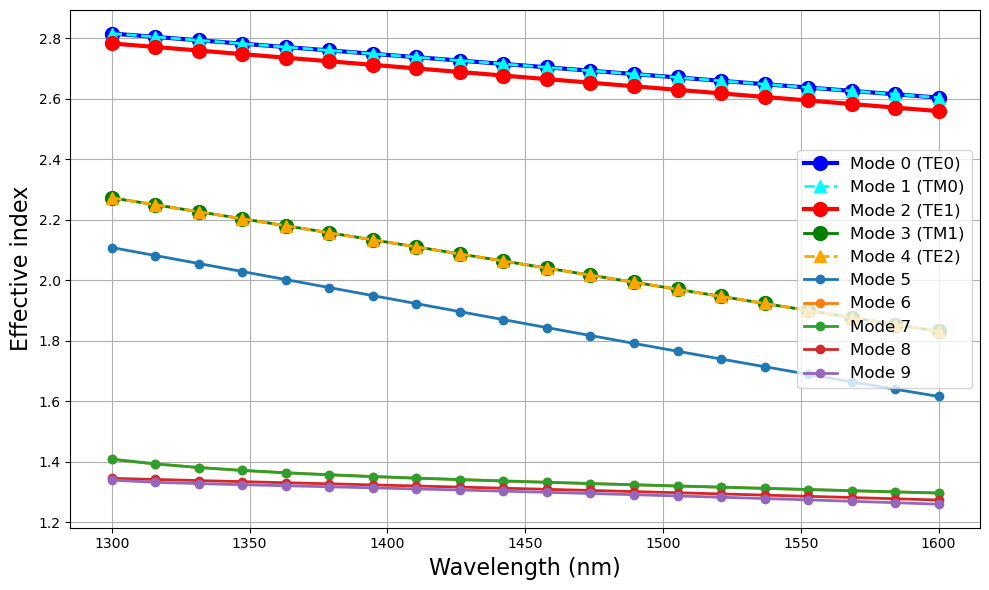


--- Vectorial fields @ 1310 nm ---
Mode 0: core power: 96.82%
Mode 1: core power: 96.82%
Mode 2: core power: 96.66%
Mode 3: core power: 94.07%
Mode 4: core power: 94.07%
Mode 5: core power: 92.74%
Mode 6: core power: 52.52%
Mode 7: core power: 52.52%
Mode 8: core power: 7.60%
Mode 9: core power: 21.29%
  TE0: n_eff=2.8092, Ez frac=0.000
  TM0: n_eff=2.7761, Ez frac=1.000
  TE3: n_eff=2.2582, Ez frac=0.000


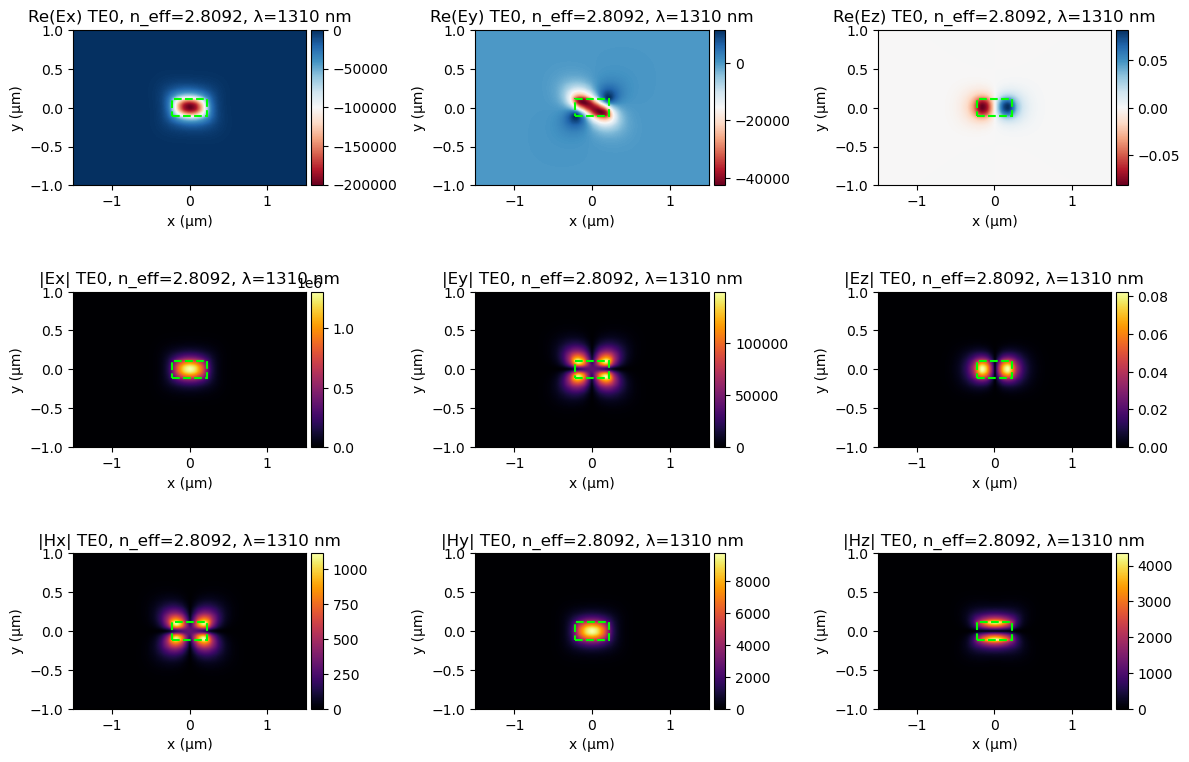

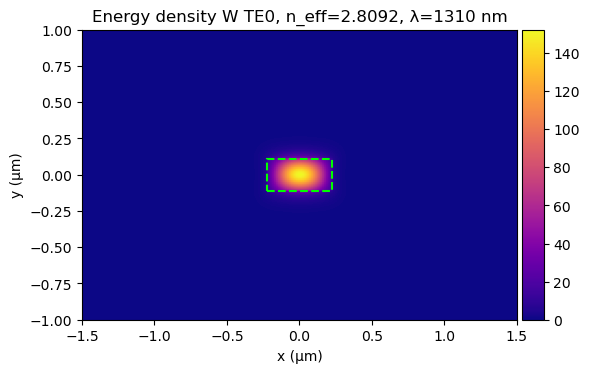

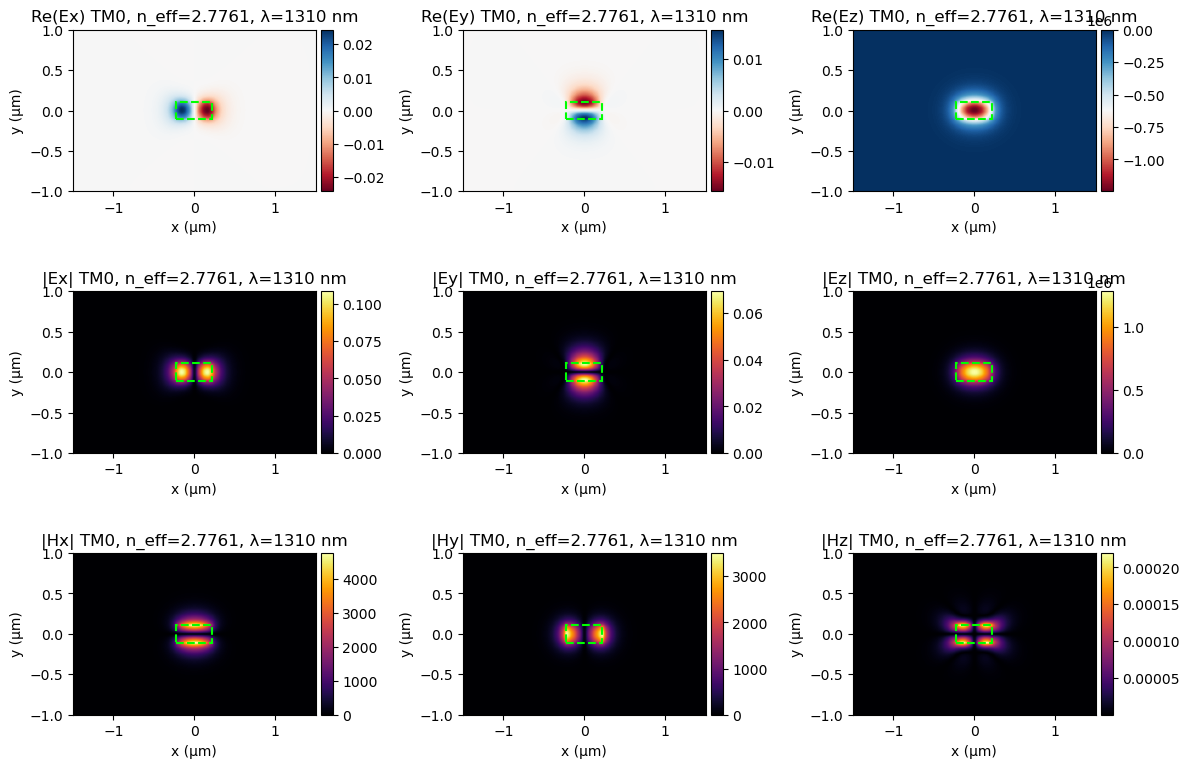

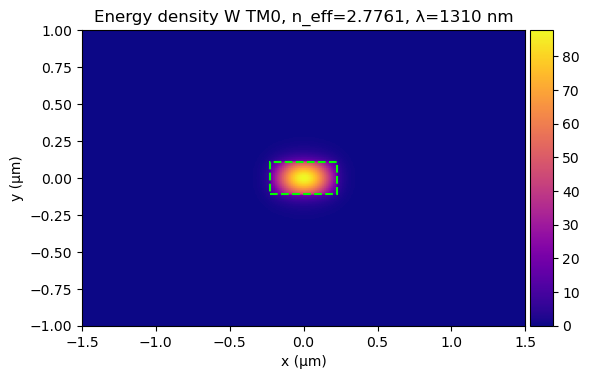

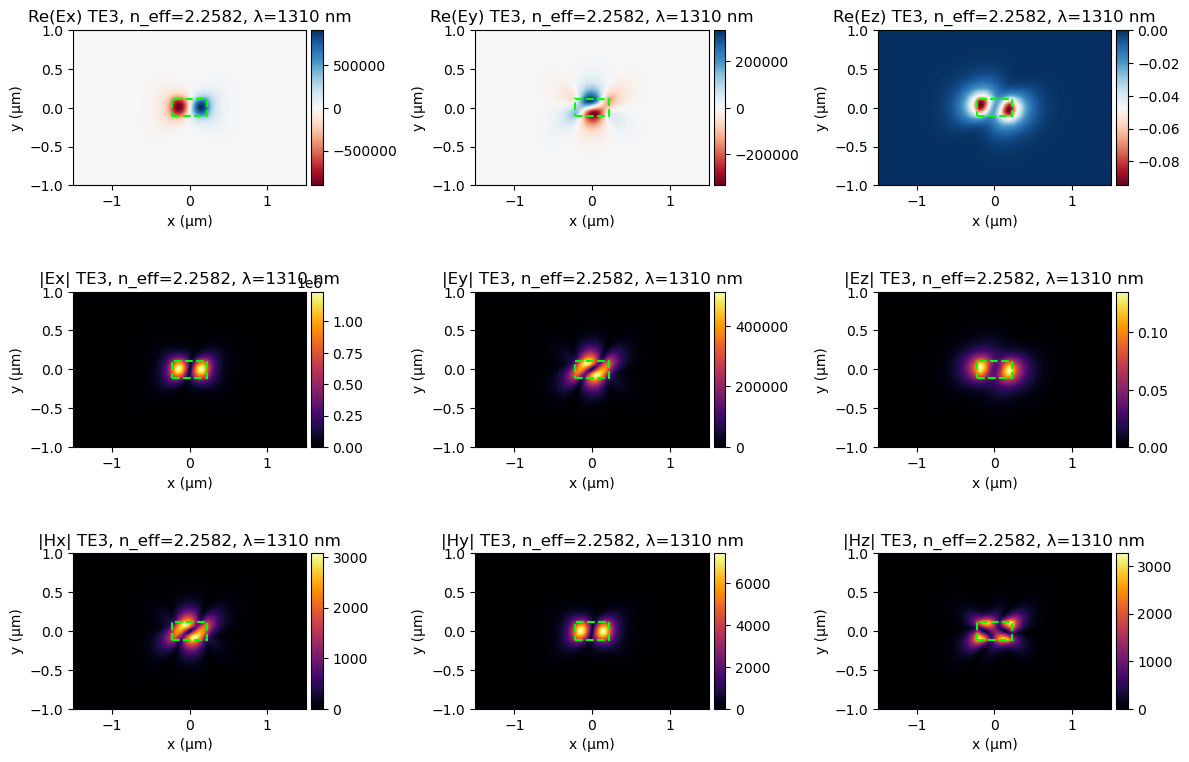

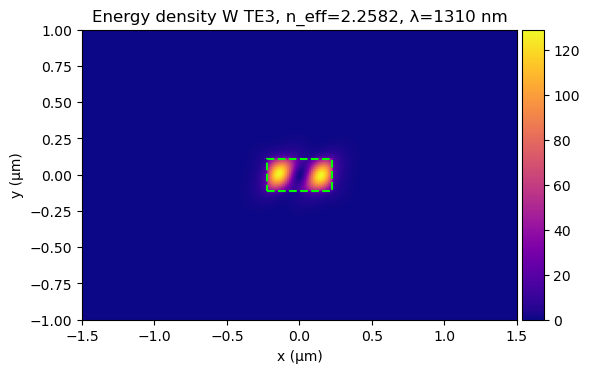


--- Vectorial fields @ 1550 nm ---
Mode 0: core power: 95.25%
Mode 1: core power: 95.25%
Mode 2: core power: 94.96%
Mode 3: core power: 89.27%
Mode 4: core power: 89.27%
Mode 5: core power: 85.07%
Mode 6: core power: 7.49%
Mode 7: core power: 7.49%
Mode 8: core power: 4.80%
Mode 9: core power: 6.31%
  TE0: n_eff=2.6395, Ez frac=0.000
  TM0: n_eff=2.5967, Ez frac=1.000
  TE3: n_eff=1.9039, Ez frac=0.000


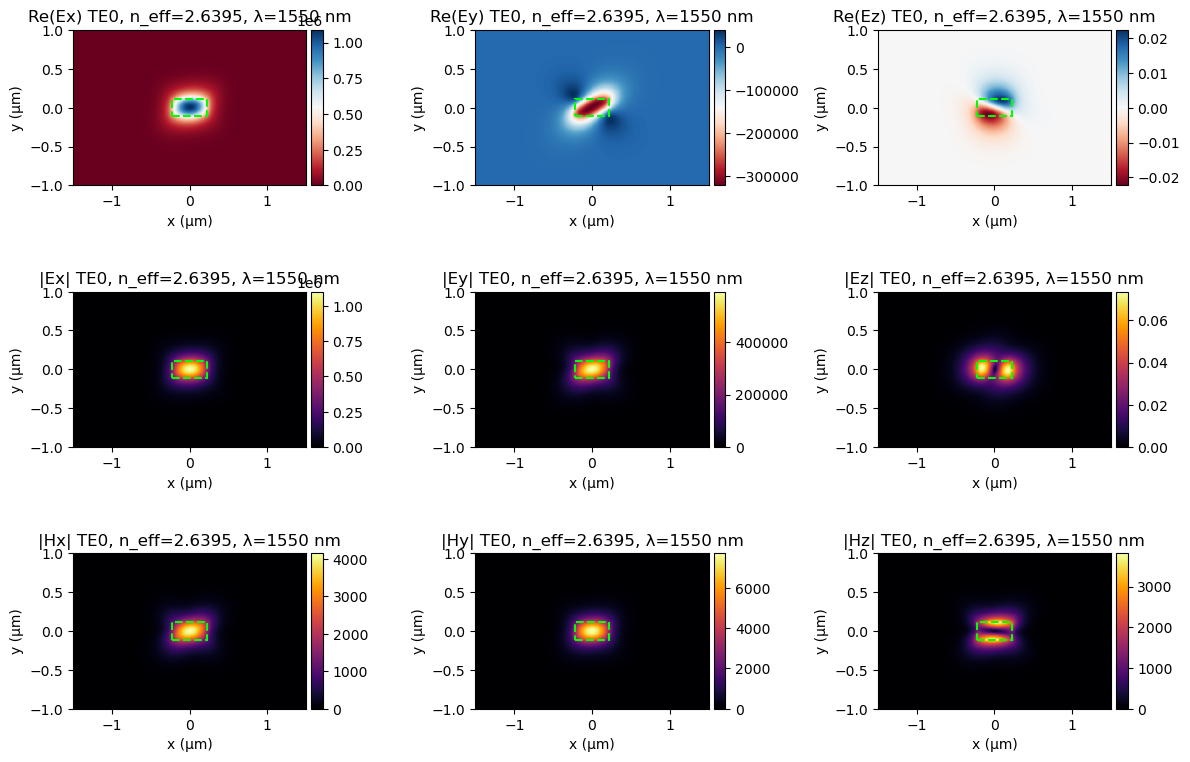

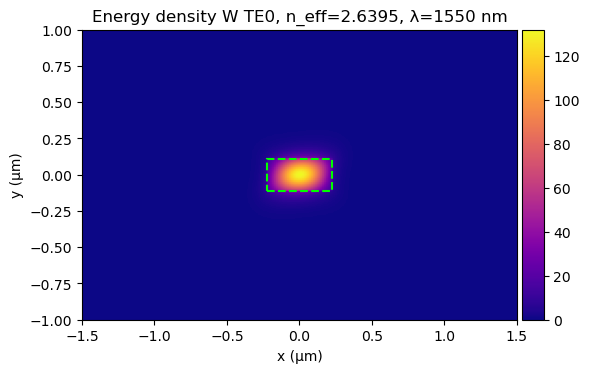

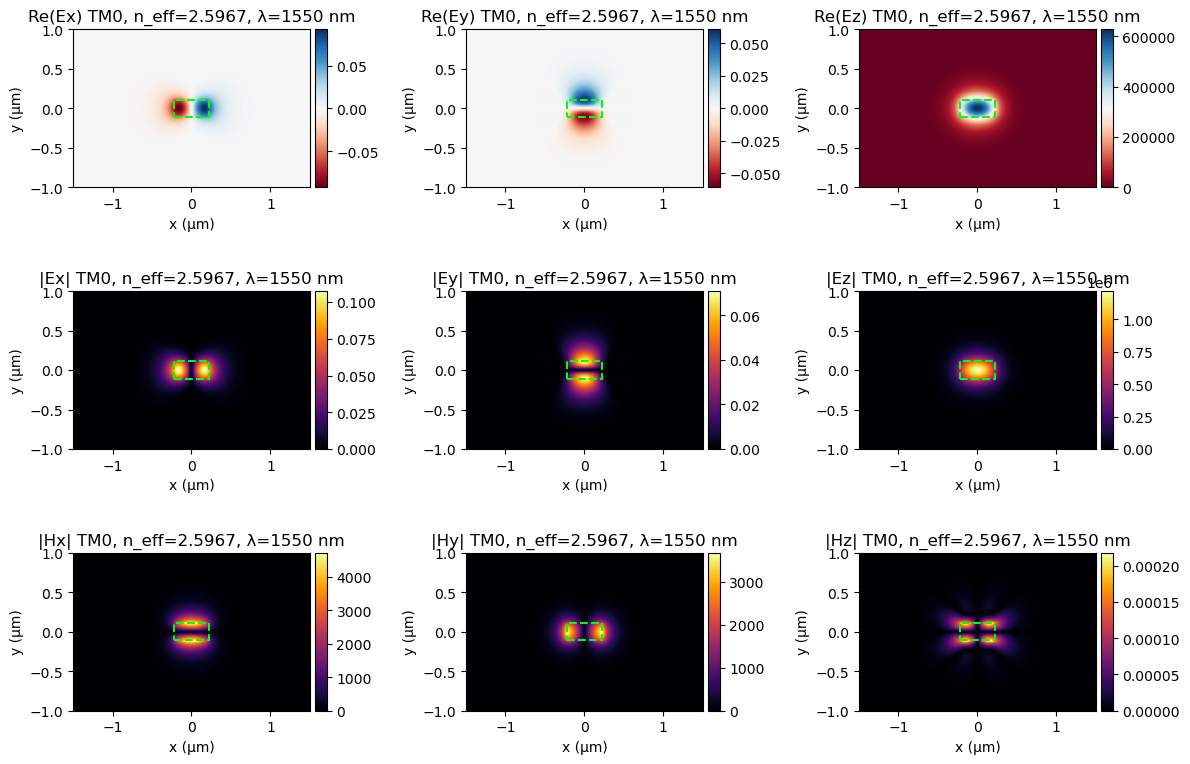

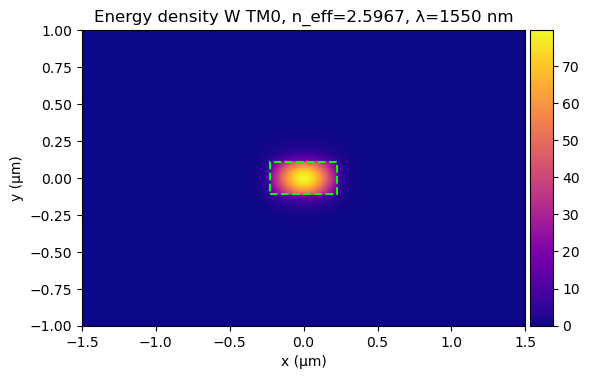

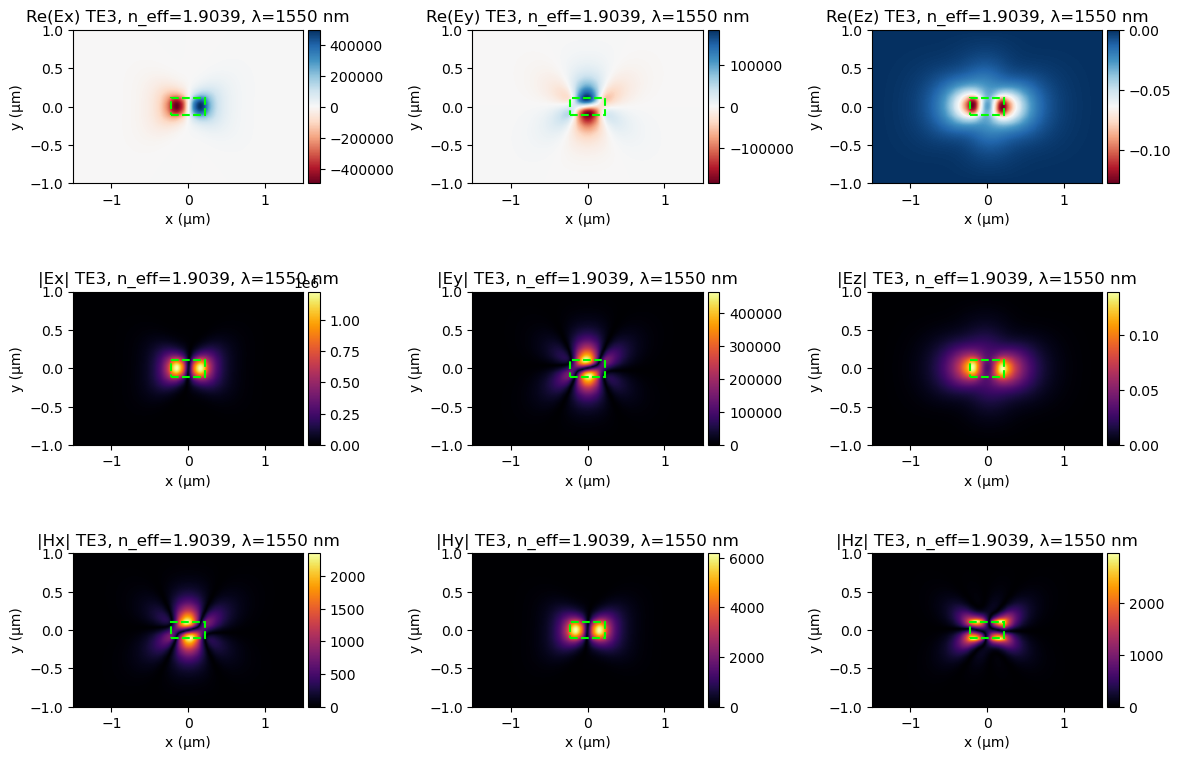

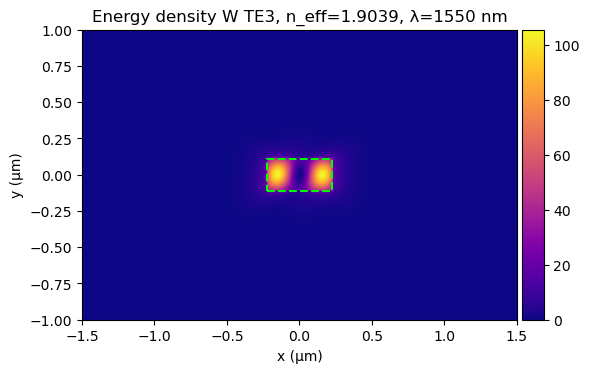

In [4]:
# make a solver instance (defaults to sweep_min wavelength unless told otherwise)
driver = WaveguideModeSolver(params)

# run the full analysis:
#   – sweep lambda range and plot dispersion
#   – at 1310 nm and 1550 nm, plot TE0, TM0, and the 5th guided mode
driver.full_analysis(plot_wavelengths=(1310e-9, 1550e-9), num_plot_modes=5)

*Higher mode was shown just because I was curious to see it. The naming TE3 is wrong because I haven't adjusted my codes for higher modes.*

# Waveguide Mode Analysis Report

## Overview
The simulation results show the effective index dispersion and core-power confinement for the first ten eigenmodes of the $450\,\mathrm{nm} \times 220\,\mathrm{nm}$ silicon-on-insulator (SOI) waveguide across the $1.3$–$1.6\,\mu\mathrm{m}$ wavelength range.


## Dispersion Characteristics
The computed dispersion curves display the expected **monotonic decrease of effective index** with increasing wavelength for all guided modes.
For the fundamental TE0 and TM0 modes, $n_\mathrm{eff}$ drops smoothly from around $2.82$ at $1300\,\mathrm{nm}$ to approximately $2.60$ at $1600\,\mathrm{nm}$. Higher-order modes exhibit the same downward slope but start at lower $n_\mathrm{eff}$ values and approach cutoff sooner.

This behavior is consistent with:
- **Material dispersion**: decreasing refractive index of silicon with wavelength in the NIR.
- **Waveguide dispersion**: mode expansion into the cladding at longer wavelengths.


## Core Power Confinement
The **core-power fraction** confirms strong confinement for the first six modes:
- **Mode 0 (TE0)**: $\sim 97\%$ core power at $1300\,\mathrm{nm}$, $\sim 95\%$ at $1600\,\mathrm{nm}$.
- **Mode 1 (TM0)**: Nearly identical to TE0 due to symmetry.
- **Mode 2 (TE1)**: $\sim 96\% \rightarrow 95\%$ over the sweep.
- **Modes 3 (TM1) and 4 (TE2)**: $\sim 94\% \rightarrow 88$–$90\%$, still well guided.
- **Mode 5**: $\sim 93\% \rightarrow \sim 83$–$87\%$, showing weaker confinement at longer wavelengths.

Modes **6–9** have very low $n_\mathrm{eff}$ ($\sim 1.26$–$1.36$ at long wavelengths) and low confinement (often below $10\%$). These are **not physically guided** but rather discretized representations of the continuum (“box modes”).


## Degeneracy Observations
Certain modes appear in **degenerate pairs** (e.g., 0–1, 3–4, 6–7) with identical effective indices and nearly identical core-power fractions.
This is expected for **symmetric, isotropic waveguides** in an idealized simulation domain:
- These pairs correspond to orthogonal polarizations (e.g., x/y oriented lobes) of the same mode family.
- In fabricated devices, small asymmetries—such as sidewall angle, stress, or fabrication bias—would slightly split these degeneracies.


## Physical Interpretation
- **Slope of $n_\mathrm{eff}(\lambda)$**: Longer wavelengths push more of the field into the cladding, lowering $n_\mathrm{eff}$ and slightly reducing confinement.
- **Order vs confinement**: Higher-order modes extend further into the cladding, resulting in lower $n_\mathrm{eff}$ and reduced confinement.


## Practical Recommendations
1. **Design relevance**: For most integrated photonics designs, focus on Modes 0–5 as the reliably guided set across the wavelength range.
2. **Suppressing spurious modes**:
   - Increase the simulation domain.
   - Add absorbing boundary conditions (PML).
   - Filter modes by requiring $n_\mathrm{clad} < \Re\{n_\mathrm{eff}\} < n_\mathrm{core}$ and a minimum core-power threshold.
3. **Breaking degeneracy (for analysis)**: Introduce a small symmetry-breaking perturbation (e.g., core offset, grid anisotropy) to observe the polarization splitting.


## Field Profile and Energy Density Analysis

When examining the computed vectorial fields for the selected modes, the patterns match the expected physical behavior for each polarization and order:

- **Fundamental TE$_0$ mode**
  The dominant electric field component is $E_x$ (transverse to the propagation direction $z$), oriented across the waveguide width.
  $E_z$ is negligible, as expected for a quasi-TE mode in a high-contrast dielectric slab.
  The magnetic field resides primarily in $H_y$ and $H_z$ in the complementary orientations.
  The energy density $W$ is strongly concentrated inside the silicon core with a single lobe and smooth decay into the cladding, indicating good confinement.

- **Fundamental TM$_0$ mode**
  The dominant electric field component is $E_z$, aligned along the propagation axis.
  $E_x$ and $E_y$ are much weaker, serving mainly to satisfy boundary conditions.
  The magnetic field is concentrated in $H_x$ and $H_y$, as expected for TM polarization.
  The energy density is again well confined to the core with a single central maximum.

- **Higher-order modes (example: 5th guided mode)**
  Field patterns show additional nodal structure - e.g., two distinct lobes in $E_x$ for TE-like modes or in $E_z$ for TM-like modes - consistent with a higher transverse order.
  The energy density still peaks inside the core but spreads further into the cladding, reflecting weaker confinement.

- **Wavelength dependence of field orientation**
  Comparing the TE$_0$ fields at $1310\,\mathrm{nm}$ and $1550\,\mathrm{nm}$, the dominant $E_x$ lobe rotates slightly in the $xy$-plane.
  This is normal: the exact field orientation depends on subtle symmetry breaking from the rectangular cross-section and the mode solver’s orthogonalization process.
  Such rotation does not affect $n_\mathrm{eff}$ or confinement and is physically equivalent for a symmetric waveguide.

- **Consistency check**
  Across wavelengths, the TE/TM identification matches the expected dominant field components, energy remains concentrated in the waveguide for low-order modes, and higher orders behave as predicted.
  These points indicate that the solver is correctly computing mode profiles and energy densities.

## Conclusion

The simulation successfully reproduces the expected modal behavior of a $450\,\mathrm{nm} \times 220\,\mathrm{nm}$ SOI waveguide across the $1.3$–$1.6\,\mu\mathrm{m}$ range.
Both **dispersion** and **field profiles** agree with theoretical predictions and known properties of high-index-contrast strip waveguides:

- $n_\mathrm{eff}$ decreases smoothly with wavelength for all guided modes, consistent with material and waveguide dispersion.
- Core-power confinement remains high ($>85\%$) for the first six modes, validating that these are truly guided.
- TE and TM polarizations exhibit the correct dominant field components ($E_x$ for TE, $E_z$ for TM) and complementary magnetic field structure.
- Energy densities are well confined for low-order modes, with higher-order modes showing expected nodal patterns and reduced confinement.
- Degenerate pairs reflect the symmetry of the idealized structure, as anticipated for isotropic cores and symmetric domains.

Minor features - such as slight $E_x$ orientation changes for TE$_0$ at different wavelengths - are physically reasonable and arise from symmetry-related mode rotation, not from solver errors.

Overall, the results confirm that the solver is accurately capturing the physical behavior of guided modes in SOI strip waveguides, providing a reliable basis for further design or optimization work.
